In [2]:
# import utils and basic libraries
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from utils.preprocessing import gen_sub, bicubic
from utils.loss import l1_loss, psnr, ssim
from utils.prediction import ensemble, unensemble, shuffle_last_axis, predict_tensor, predict_tensor_permute, savePredictions, savePredictionsPermut
from utils.network import Super3D
from utils.training import Trainer
from skimage import io
from zipfile import ZipFile

/Users/shubham/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shubham/Library/Python/3.9/lib/python/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  war

In [4]:
#-------------
# General Settings
#-------------
PATH_DATASET = 'dataset' # pre-processed dataset path
name_net = 'Super3D' # name of the network
LR_SIZE = 128 # pathces dimension
SCALE = 3 # upscale of the proba-v dataset is 3
HR_SIZE = LR_SIZE * SCALE # upscale of the dataset is 3
OVERLAP = 32 # overlap between pathces
CLEAN_PATH_PX = 0.85 # percentage of clean pixels to accept a patch
band = 'NIR' # choose the band for the training
checkpoint_dir = f'ckpt/{band}_{name_net}' # weights path
log_dir = 'logs' # tensorboard logs path


In [5]:
#-------------
# Network Settings
#-------------
FILTERS = 32 # features map in the network
KERNEL_SIZE = 3 # convolutional kernel size dimension (either 3D and 2D)
CHANNELS = 9 # number of temporal steps
R = 8 # attention compression
N = 12 # number of residual feature attention blocks
lr = 1e-4 # learning rate (Nadam optimizer)
BATCH_SIZE = 32 # batch size
EPOCHS_N = 10 # number of epochs

<a id="loading"></a>
# 1.0 Dataset Loading

In [6]:
# load validation 
X_val = np.load(os.path.join(PATH_DATASET, f'X_{band}_val.npy'))
y_val = np.load(os.path.join(PATH_DATASET, f'y_{band}_val.npy'))
y_val_mask = np.load(os.path.join(PATH_DATASET, f'y_{band}_val_masks.npy'))

In [7]:
# load ESA test set (no ground truth)
X_test = np.load(os.path.join(PATH_DATASET, f'X_{band}_test.npy'))

In [8]:
# print loaded dataset info
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('y_val_mask: ', y_val_mask.shape)

print('X_test: ', X_test.shape)

X_val:  (20, 128, 128, 9)
y_val:  (20, 384, 384, 1)
y_val_mask:  (20, 384, 384, 1)
X_test:  (27, 128, 128, 9)


<a id="network"></a>
# 2.0 Load the Network

In [9]:
# build Super3D network
Super3D_network = Super3D(scale=SCALE, filters=FILTERS, 
                 kernel_size=KERNEL_SIZE, channels=CHANNELS, r=R, N=N)

<a id="test"></a>
# 3.0 Test the Network

## 3.1 Qualitative results

/var/folders/9f/h04986196vjc5s7zl1cgqbyr0000gn/T/ipykernel_31685/2269657601.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


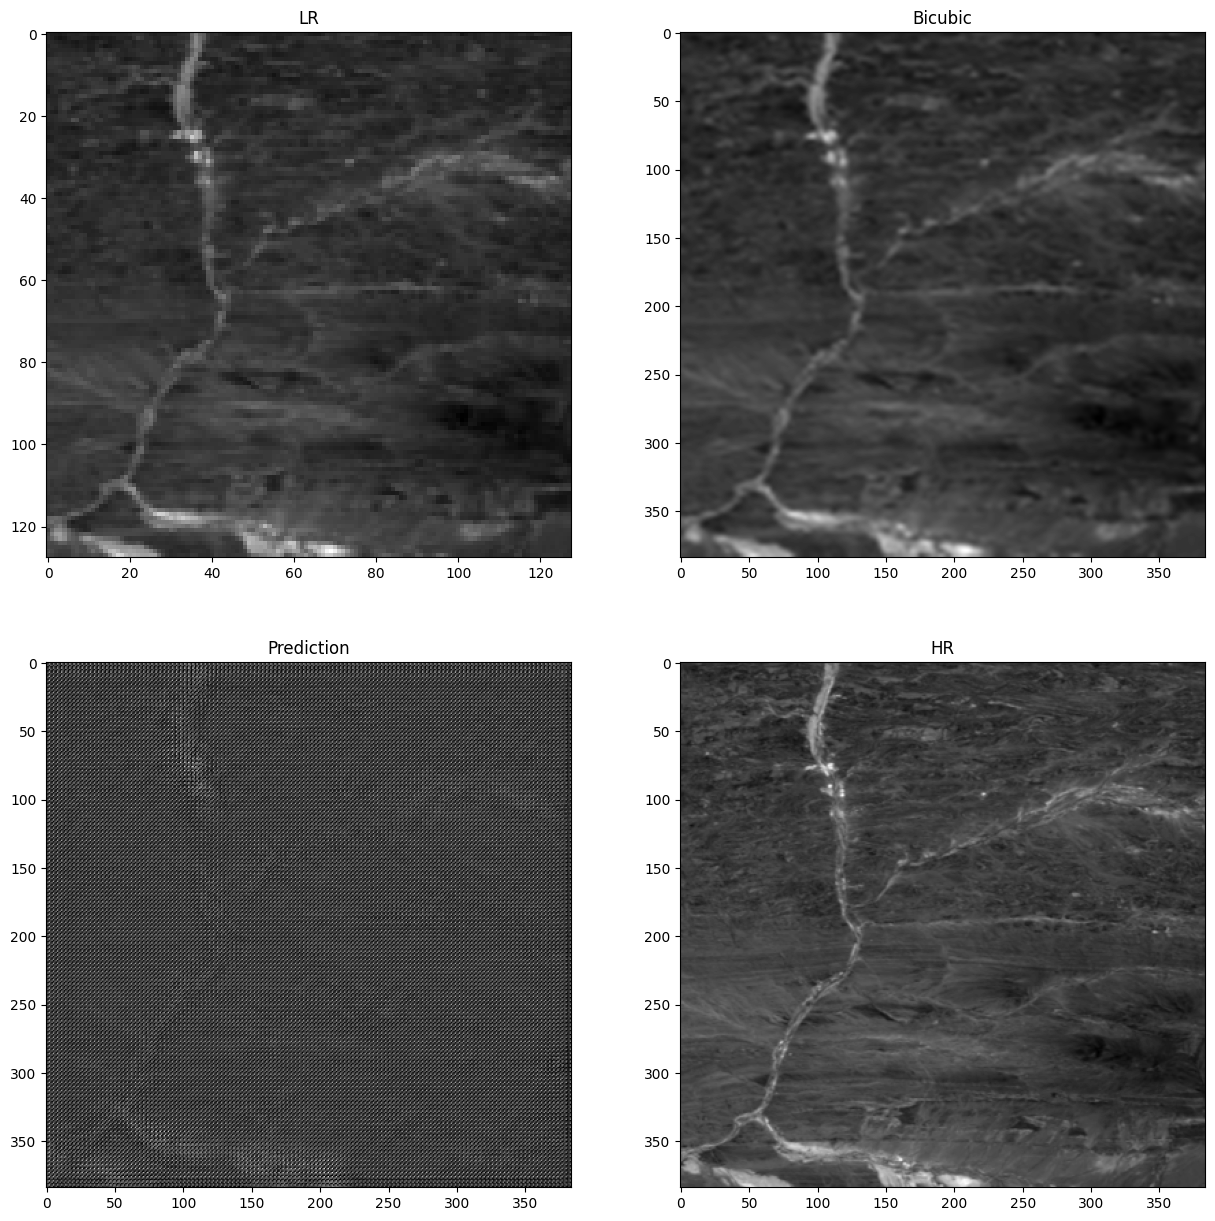

In [17]:
# print example images
index = 5 # choose an image from validation set

x_pred = predict_tensor(Super3D_network, X_val[index:index+1])

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(X_val[index,:,:,0], cmap = 'gray')
ax[0,0].set_title('LR')
ax[0,1].imshow(bicubic(np.mean(X_val[index:index+1], axis=-1)[...,None])[0,:,:,0], cmap ='gray')
ax[0,1].set_title('Bicubic')
ax[1,0].imshow(x_pred[0,:,:,0], cmap ='gray')
ax[1,0].set_title('Prediction')
ax[1,1].imshow(y_val[index,:,:,0], cmap = 'gray')
ax[1,1].set_title('HR')
fig.show()

## 3.2 Compute Super3D cPSNR

In [12]:
# compute cPSNR with trained network
psnr_scores = []

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor(Super3D_network, X_val[index:index+1])
    psnr_scores.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
# print validation network cPSNR
print(f'PSNR Validation Network: {np.mean(psnr_scores)}')

PSNR Validation Network: 22.388607025146484


In [18]:
# compute cPSNR with bicubic interpolation
psnr_scores_bicubic = []

for index in tqdm(range(X_val.shape[0])):
    x_pred = bicubic(np.mean(X_val[index:index+1], axis=-1)[...,None])
    psnr_scores_bicubic.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
# print validation bicubic cPSNR
print(f'PSNR Validation Bicubic: {np.mean(psnr_scores_bicubic)}')

PSNR Validation Bicubic: 45.542945861816406


## 3.3 Compute Super3D+ cPSNR

In [21]:
# compute Ensemble PSNR prediction
psnr_scores_plus = []
n_permut = 20 # number of permutations

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor_permute(Super3D_network, X_val[index],n_ens=n_permut)
    psnr_scores_plus.append(psnr(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
# print validation Ensamble cPSNR
print(f'PSNR Validation Ensamble: {np.mean(psnr_scores_plus)}')

PSNR Validation Ensamble: 22.778034210205078


## 3.4 Compute Super3D SSIM

In [23]:
# compute SSIM with trained network
ssim_scores = []

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor(Super3D_network, X_val[index:index+1])
    ssim_scores.append(ssim(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
# print validation network SSIM
print(f'SSIM Validation Network: {np.mean(ssim_scores)}')

SSIM Validation Network: 0.19857385754585266


## 3.5 Computer Super3D+ SSIM

In [25]:
# compute Ensemble SSIM prediction
ssim_scores_ens = []
n_permut = 20 # number of permutations

for index in tqdm(range(X_val.shape[0])):
    x_pred = predict_tensor_permute(Super3D_network, X_val[index],n_ens=n_permut)
    ssim_scores_ens.append(ssim(y_val[index:index+1,:,:], x_pred, y_val_mask[index:index+1,:,:], HR_SIZE).numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
# print validation Ensamble SSIM
print(f'PSNR Validation: {np.mean(ssim_scores_ens)}')

PSNR Validation: 0.2087756097316742


<a id="proba"></a>
# 4.0 Predict Proba-V Test Set

In [27]:
# create submission folder
if not os.path.exists(submission_dir):
    os.mkdir(submission_dir)

## 4.1 Super3D prediction

In [28]:
X_val.shape

(20, 128, 128, 9)

In [29]:
X_test.shape

(27, 128, 128, 9)

In [30]:
# predict proba-v test set with Super3D
X_preds = []

for index in tqdm(range(X_test.shape[0])):
    X_preds.append(predict_tensor(Super3D_network, X_test[index:index+1]))

  0%|          | 0/27 [00:00<?, ?it/s]

In [34]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 4.2 Super3D+ prediction

In [36]:
# predict proba-v test set with Super3D+
X_preds = []
n_permut = 20 # number of permutations

for index in tqdm(range(X_test.shape[0])):
    X_preds.append(predict_tensor_permute(Super3D_network, X_test[index], n_ens=n_permut))

  0%|          | 0/27 [00:00<?, ?it/s]

In [40]:
# save predictions in submission_dir
savePredictionsPermut(X_preds, band, submission_dir)

100%|██████████| 27/27 [00:01<00:00, 21.76it/s]


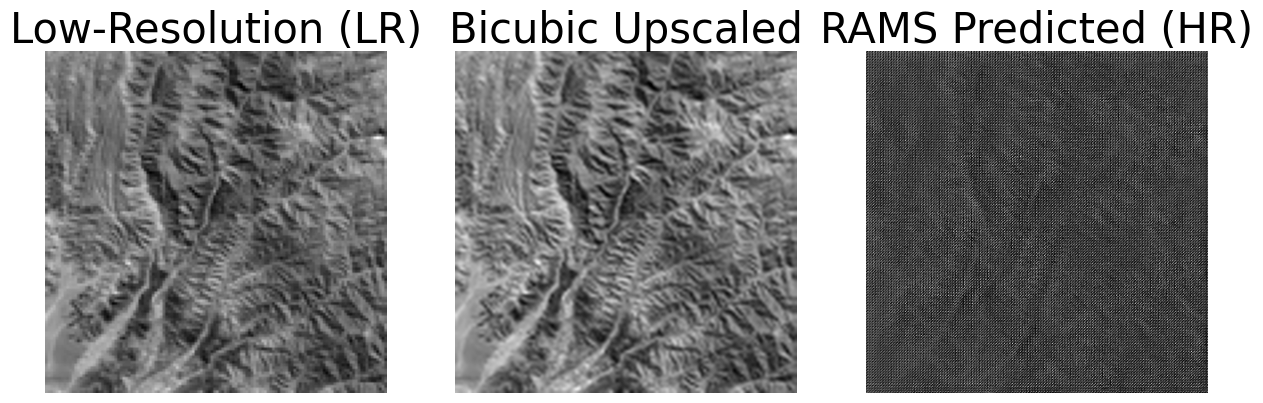

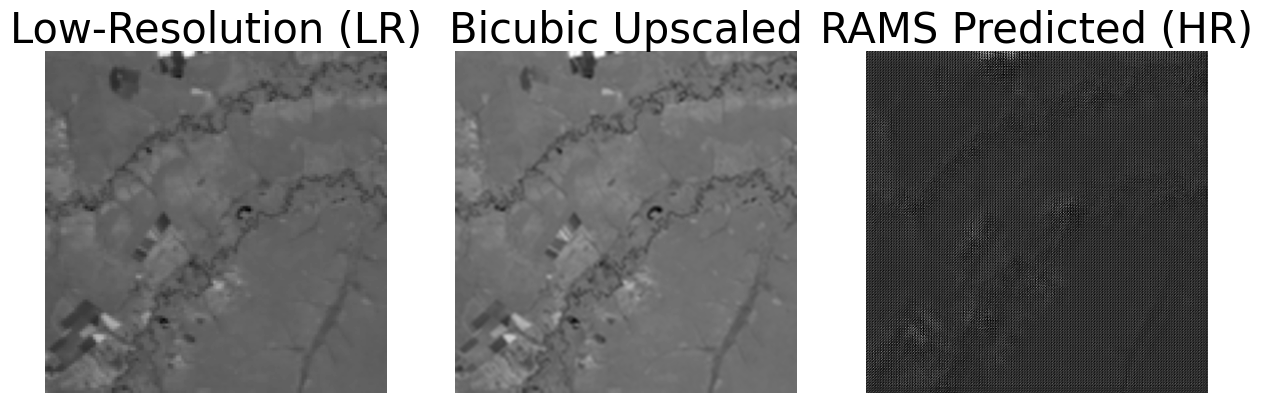

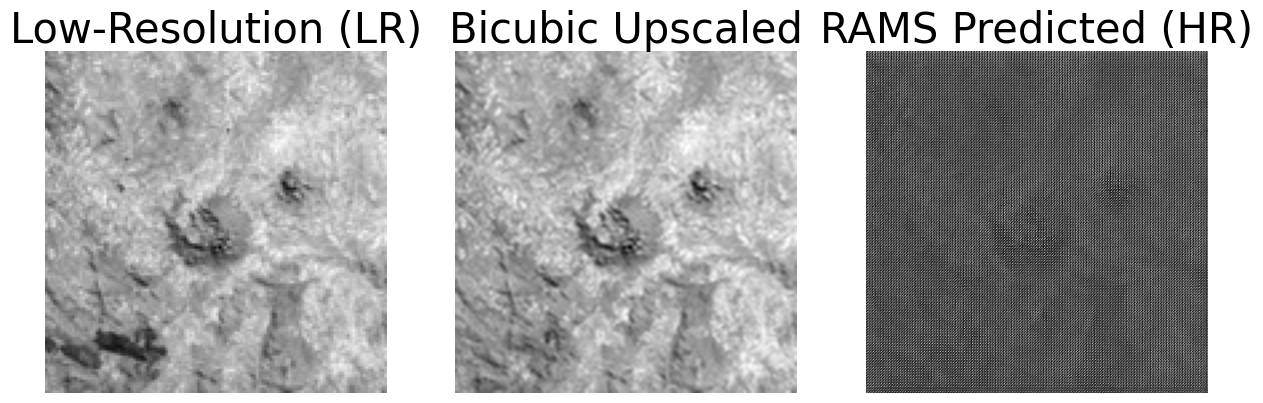

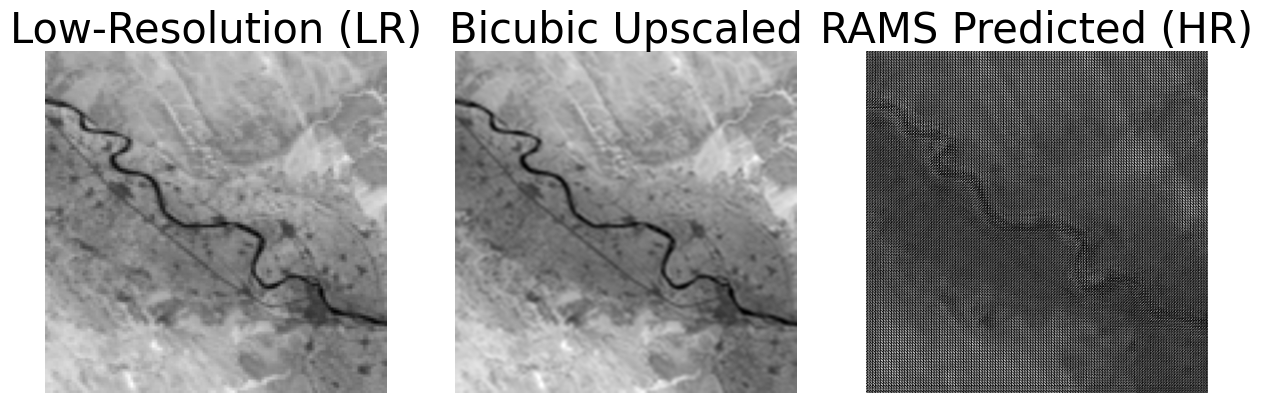

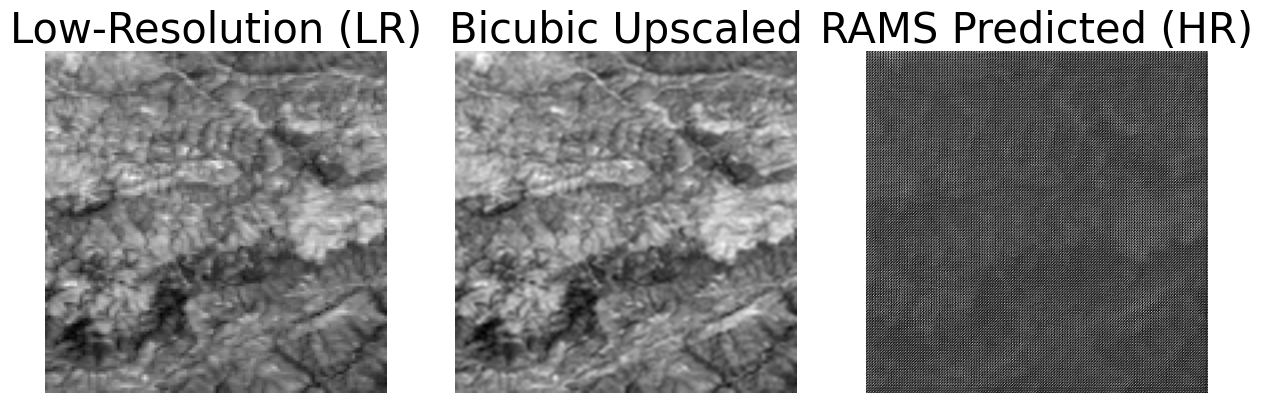

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
from utils.preprocessing import bicubic  # Ensure this import is correct

def visualize_predictions(X_test, X_preds, num_images=5):
    """
    Visualize a few test images, their bicubic upscaled versions, and Super3D predicted images.
    
    Parameters:
    ----------
    X_test : numpy.ndarray
        Low-resolution test images of shape (N, H, W, C).
    X_preds : list or numpy.ndarray
        Predicted high-resolution images. Each element should be of shape (1, H*scale, W*scale, C).
    num_images : int
        Number of images to visualize. Default is 5.
    """
    # Validate inputs
    if not isinstance(X_test, np.ndarray):
        raise TypeError("X_test must be a NumPy array.")
    
    if not isinstance(X_preds, (list, np.ndarray)):
        raise TypeError("X_preds must be a list or NumPy array.")
    
    if len(X_test) != len(X_preds):
        raise ValueError("X_test and X_preds must have the same length.")
    
    # Select random indices to visualize
    indices = np.random.choice(len(X_test), size=num_images, replace=False)
    
    for idx in indices:
        # Get low-resolution image
        lr_image = X_test[idx]
        
        # Generate bicubic upscaled image
        # Assuming X_test has shape (N, H, W, C)
        # If not, adjust the indexing accordingly
        bicubic_image = bicubic(np.mean(X_test[idx:idx+1], axis=-1)[..., None], scale=3)[0, :, :, 0]
        
        # Get predicted high-resolution image
        # Assuming X_preds[idx] has shape (1, H*scale, W*scale, C)
        pred_image = X_preds[idx][0, :, :, 0]  # Adjust indices if shape differs
        
        # Plot the images
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        # Low-Resolution Image
        ax[0].imshow(lr_image[:, :, 0], cmap='gray')
        ax[0].set_title('Low-Resolution (LR)')
        ax[0].axis('off')
        
        # Bicubic Upscaled Image
        ax[1].imshow(bicubic_image, cmap='gray')
        ax[1].set_title('Bicubic Upscaled')
        ax[1].axis('off')
        
        # Super3D Predicted Image
        ax[2].imshow(pred_image, cmap='gray')
        ax[2].set_title('Super3D Predicted (HR)')
        ax[2].axis('off')
        
        plt.show()

# Example usage:
visualize_predictions(X_test, X_preds, num_images=5)